In [2]:
!pip install mne

     |████████████████████████████████| 7.0MB 6.6MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Helper methods to process EDF data file.

In [4]:
#Source : https://github.com/akaraspt/deepsleepnet
import re, operator, logging
import numpy as np
from collections import namedtuple
import h5py
import random
from datetime import datetime
EVENT_CHANNEL = 'EDF Annotations'
log = logging.getLogger(__name__)

class EDFEndOfData: pass

WINDOW_SIZE = 100

def rescale_array(X):
    X = X / 20
    X = np.clip(X, -5, 5)
    return X


def aug_X(X):
    scale = 1 + np.random.uniform(-0.1, 0.1)
    offset = np.random.uniform(-0.1, 0.1)
    noise = np.random.normal(scale=0.05, size=X.shape)
    X = scale * X + offset + noise
    return X

def gen(dict_files, aug=False):
    while True:
        record_name = random.choice(list(dict_files.keys()))
        batch_data = dict_files[record_name]
        all_rows = batch_data['x']

        for i in range(10):
            start_index = random.choice(range(all_rows.shape[0]-WINDOW_SIZE))

            X = all_rows[start_index:start_index+WINDOW_SIZE, ...]
            Y = batch_data['y'][start_index:start_index+WINDOW_SIZE]

            X = np.expand_dims(X, 0)
            Y = np.expand_dims(Y, -1)
            Y = np.expand_dims(Y, 0)

            if aug:
                X = aug_X(X)
            X = rescale_array(X)

            yield X, Y


def chunker(seq, size=WINDOW_SIZE):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def tal(tal_str):
  exp = '(?P<onset>[+\-]\d+(?:\.\d*)?)' + \
        '(?:\x15(?P<duration>\d+(?:\.\d*)?))?' + \
        '(\x14(?P<annotation>[^\x00]*))?' + \
        '(?:\x14\x00)'

  def annotation_to_list(annotation):
    # print('annotatn:',annotation)
    return str(annotation).split('\x14') if annotation else []

  def parse(dic):
    return (
    float(dic['onset']), float(dic['duration']) if dic['duration'] else 0., annotation_to_list(dic['annotation']))

  return [parse(m.groupdict()) for m in re.finditer(exp, tal_str)]

def edf_header(f):
    h = {}
    assert f.tell() == 0  # check file position
    assert f.read(8) == '0       '
    # recording info)
    h['local_subject_id'] = f.read(80).strip()
    h['local_recording_id'] = f.read(80).strip()
    # parse timestamp
    (day, month, year) = [int(x) for x in re.findall('(\d+)', f.read(8))]
    (hour, minute, sec) = [int(x) for x in re.findall('(\d+)', f.read(8))]
    h['date_time'] = str(datetime(year + 2000, month, day, hour, minute, sec))
    # misc
    header_nbytes = int(f.read(8))
    subtype = f.read(44)[:5]
    h['EDF+'] = subtype in ['EDF+C', 'EDF+D']
    h['contiguous'] = subtype != 'EDF+D'
    h['n_records'] = int(f.read(8))
    h['record_length'] = float(f.read(8))  # in seconds
    nchannels = h['n_channels'] = int(f.read(4))
    # read channel info
    channels = range(h['n_channels'])
    h['label'] = [f.read(16).strip() for n in channels]
    h['transducer_type'] = [f.read(80).strip() for n in channels]
    h['units'] = [f.read(8).strip() for n in channels]
    h['physical_min'] = np.asarray([float(f.read(8)) for n in channels])
    h['physical_max'] = np.asarray([float(f.read(8)) for n in channels])
    h['digital_min'] = np.asarray([float(f.read(8)) for n in channels])
    h['digital_max'] = np.asarray([float(f.read(8)) for n in channels])
    h['prefiltering'] = [f.read(80).strip() for n in channels]
    h['n_samples_per_record'] = [int(f.read(8)) for n in channels]
    f.read(32 * nchannels)  # reserved
    assert f.tell() == header_nbytes
    return h

class BaseEDFReader:
  def __init__(self, file, verbose=False):
    self.file = file
    self.verbose = verbose

  def read_header(self):
    if self.verbose:
        print('read_header')
    self.header = h = edf_header(self.file)
    # calculate ranges for rescaling
    self.dig_min = h['digital_min']
    self.phys_min = h['physical_min']
    phys_range = h['physical_max'] - h['physical_min']
    dig_range = h['digital_max'] - h['digital_min']
    assert np.all(phys_range > 0)
    assert np.all(dig_range > 0)
    self.gain = phys_range / dig_range

  def read_raw_record(self):
    if self.verbose:
        print('read raw record')
    # Read a record with data and return a list containing arrays with raw bytes.
    result = []
    for nsamp in self.header['n_samples_per_record']:
      samples = self.file.read(nsamp * 2)
      if len(samples) != nsamp * 2:
        raise EDFEndOfData
      result.append(samples)
    return result

  def convert_record(self, raw_record):
    if self.verbose:
        print('convert record')
    # Convert a raw record to a (time, signals, events) tuple based on information in the header.
    h = self.header
    dig_min, phys_min, gain = self.dig_min, self.phys_min, self.gain
    time = float('nan')
    signals = []
    events = []
    for (i, samples) in enumerate(raw_record):
      if h['label'][i] == EVENT_CHANNEL:
        ann = tal(samples)
        time = ann[0][0]
        events.extend(ann[1:])
      # print(i, samples)
      # exit()
      else:
        # 2-byte little-endian integers
        dig = np.fromstring(samples, '<i2').astype(np.float32)
        phys = (dig - dig_min[i]) * gain[i] + phys_min[i]
        signals.append(phys)
    return time, signals, events

  def read_record(self):
    if self.verbose:
        print('read_record')
    return self.convert_record(self.read_raw_record())

  def records(self):
    if self.verbose:
        print('record self')
    # Record generator.
    yield self.read_record()
    """try:
        while True:
            yield self.read_record()
    except EDFEndOfData:
        pass"""

def load_edf(edffile):
  
  """Load an EDF+ file.
    Very basic reader for EDF and EDF+ files. While BaseEDFReader does support
    exotic features like non-homogeneous sample rates and loading only parts of
    the stream, load_edf expects a single fixed sample rate for all channels and
    tries to load the whole file.

    Parameters
    ----------
    edffile : file-like object or string

    Returns
    -------
    Named tuple with the fields:
    X : NumPy array with shape p by n.
    Raw recording of n samples in p dimensions.
    sample_rate : float
    The sample rate of the recording. Note that mixed sample-rates are not
    supported.
    sens_lab : list of length p with strings
    The labels of the sensors used to record X.
    time : NumPy array with length n
    The time offset in the recording for each sample.
    annotations : a list with tuples      EDF+ annotations are stored in (start, duration, description) tuples.
    start : float
      Indicates the start of the event in seconds.
    duration : float
      Indicates the duration of the event in seconds.
    description : list with strings
      Contains (multiple?) descriptions of the annotation event."""
      
  if isinstance(edffile, basestring):
    with open(edffile, 'rb') as f:
      return load_edf(f)  # convert filename to file
  reader = BaseEDFReader(edffile)
  reader.read_header()
  h = reader.header
  log.debug('EDF header: %s' % h)
  # get sample rate info
  nsamp = np.unique(
    [n for (l, n) in zip(h['label'], h['n_samples_per_record'])
     if l != EVENT_CHANNEL])
  assert nsamp.size == 1, 'Multiple sample rates not supported!'
  sample_rate = float(nsamp[0]) / h['record_length']
  rectime, X, annotations = zip(*reader.records())
  X = np.hstack(X)
  annotations = reduce(operator.add, annotations)
  chan_lab = [lab for lab in reader.header['label'] if lab != EVENT_CHANNEL]
  # create timestamps
  if reader.header['contiguous']:
    time = np.arange(X.shape[1]) / sample_rate
  else:
    reclen = reader.header['record_length']
    within_rec_time = np.linspace(0, reclen, nsamp, endpoint=False)
    time = np.hstack([t + within_rec_time for t in rectime])
  tup = namedtuple('EDF', 'X sample_rate chan_lab time annotations')
  return tup(X, sample_rate, chan_lab, time, annotations)

In [5]:
import ntpath
import random, os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from mne.datasets.sleep_physionet._utils import _fetch_one, _data_path, AGE_SLEEP_RECORDS, _check_subjects
from datetime import datetime

In [6]:
# Sleep stage constants

W = 0
N1 = 1
N2 = 2
N3 = 3
REM = 4
UNKNOWN = 5

#used
label_dict = {
    "W": W,
    "N1": N1,
    "N2": N2,
    "N3": N3,
    "REM": REM,
    "UNKNOWN": UNKNOWN
}

class_dict = {
    0: "W",
    1: "N1",
    2: "N2",
    3: "N3",
    4: "REM",
    5: "UNKNOWN"
}

annot2label = {
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4,
    "Sleep stage ?": 5,
    "Movement time": 5
}
project_path = os.path.abspath(os.getcwd())+'/drive/MyDrive'
print(project_path)

/content/drive/MyDrive


# Fetching data files from physionet.org and store in current Google drive

In [7]:
# Source https://github.com/swayanshu/Sleep-Stage-Classification/blob/master/DM_Final_Project.ipynb
data_path = _data_path
BASE_URL = 'https://physionet.org/physiobank/database/sleep-edfx/sleep-cassette/'
def fetch_data(subjects, recording=[1, 2], path=None, force_update=False,
               update_path=None, base_url=BASE_URL,
               verbose=None):  # noqa: D301
    records = np.loadtxt(AGE_SLEEP_RECORDS,
                         skiprows=1,
                         delimiter=',',
                         usecols=(0, 1, 2, 6, 7),
                         dtype={'names': ('subject', 'record', 'type', 'sha',
                                          'fname'),
                                'formats': ('<i2', 'i1', '<S9', 'S40', '<S22')}
                         )
    psg_records = records[np.where(records['type'] == b'PSG')]
    hyp_records = records[np.where(records['type'] == b'Hypnogram')]

    path = data_path(path=path, update_path=update_path)
    params = [path, force_update, base_url]
    fnames = []
    for subject in subjects:
        for idx in np.where(psg_records['subject'] == subject)[0]:
            if psg_records['record'][idx] in recording:
                psg_fname = _fetch_one(psg_records['fname'][idx].decode(),
                                       psg_records['sha'][idx].decode(),
                                       *params)
                hyp_fname = _fetch_one(hyp_records['fname'][idx].decode(),
                                       hyp_records['sha'][idx].decode(),
                                       *params)
                fnames.append([psg_fname, hyp_fname])

    return fnames

In [8]:
# Source https://github.com/swayanshu/Sleep-Stage-Classification/blob/master/DM_Final_Project.ipynb

subjects_list = []  # list to keep the address of the subject data
except_sub = [13, 36, 52]  # omitting the subjects with incomplete data 
for i in range(83):
    if i in except_sub:
        continue
    subjects_list.append(i)
# fetching data of each subject and 
subject_files = fetch_data(subjects=subjects_list, recording=[1, 2], path= project_path)

# Creating the .NPZ files from the EDF raw data

In [10]:
# Source https://github.com/swayanshu/Sleep-Stage-Classification/blob/master/DM_Final_Project.ipynb

from tqdm.notebook import tqdm
from mne import Epochs, pick_types, find_events
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import psd_welch

mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}
VBS = True  # constant boolean to enable/disbale verbose
EPOCH_SEC_SIZE = 30  # Epoch duration selection
seed = 42  # seed value for the random seeds
number_of_subj = 80  # Number of patients         
ch_labels =  ['EEG Fpz-Cz', 'EEG Pz-Oz']  # channels to be selected

output_path = os.path.join(project_path, "NPZ_files")  # path to save the npz files
#loop to preprocess input data and save the results in npz files to be used in our models later
for item in tqdm(subject_files):
    filename = ntpath.basename(item[0]).replace("-PSG.edf", ".npz")  # reading the PSG files
    if not os.path.exists(os.path.join(output_path, filename)):
        raw_train = mne.io.read_raw_edf(item[0], verbose=VBS)
        sampling_rate = raw_train.info['sfreq']
        raw_ch_df = raw_train.to_data_frame(scalings=100.0)[ch_labels]
        #raw_ch_df = raw_ch_df.to_frame()
        raw_ch_df.set_index(np.arange(len(raw_ch_df)))
        
        # reading the raw headers using the EDFReader function from edfreader
        f = open(item[0], 'r', errors='ignore', encoding='utf-8')
        head_raw_read = BaseEDFReader(f)
        head_raw_read.read_header()
        head_raw = head_raw_read.header
        f.close()
        raw_start_time = datetime.strptime(head_raw['date_time'], "%Y-%m-%d %H:%M:%S")

        # read annotations from hypnogram file
        f = open(item[1], 'r')
        annot_raw_read = BaseEDFReader(f)
        annot_raw_read.read_header()
        annot_raw = annot_raw_read.header
        temp, temp, total_annot = zip(*annot_raw_read.records())
        f.close()
        annot_start_time = datetime.strptime(annot_raw['date_time'], "%Y-%m-%d %H:%M:%S")
        assert raw_start_time == annot_start_time  # making sure that the PSG files and hypnogram files are in sync
        remove_idx = []    # list to keep the indicies of data that will be removed
        labels = []        # list to keep the indicies of data that have labels
        label_idx = []
        
        # selecting the indicies of known labels and adding the rest to remove_idx list
        for annot in total_annot[0]:
            onset_sec, duration_sec, annot_char = annot
            annot_str = "".join(annot_char)
            label = annot2label[annot_str]
            if label != UNKNOWN:
                if duration_sec % EPOCH_SEC_SIZE != 0:
                    raise Exception("Please choose anothe epoch duration!")
                duration_epoch = int(duration_sec / EPOCH_SEC_SIZE)
                label_epoch = np.ones(duration_epoch, dtype=np.int) * label
                labels.append(label_epoch)
                idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
                label_idx.append(idx)
            else:
                idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=np.int)
                remove_idx.append(idx)
        labels = np.hstack(labels)
        if len(remove_idx) > 0:
            remove_idx = np.hstack(remove_idx)
            select_idx = np.setdiff1d(np.arange(len(raw_ch_df)), remove_idx)
        else:
            select_idx = np.arange(len(raw_ch_df))

        # filtering data with labels only
        label_idx = np.hstack(label_idx)
        select_idx = np.intersect1d(select_idx, label_idx)

        # removing extra indicies
        if len(label_idx) > len(select_idx):
            extra_idx = np.setdiff1d(label_idx, select_idx)
            # trimming the tail
            if np.all(extra_idx > select_idx[-1]):
                n_trims = len(select_idx) % int(EPOCH_SEC_SIZE * sampling_rate)
                n_label_trims = int(math.ceil(n_trims / (EPOCH_SEC_SIZE * sampling_rate)))
                select_idx = select_idx[:-n_trims]
                labels = labels[:-n_label_trims]

        # removing all unknown and movement labels
        raw_ch = raw_ch_df.values[select_idx]

        # check if we can split into epochs' size
        if len(raw_ch) % (EPOCH_SEC_SIZE * sampling_rate) != 0:
            raise Exception("Please choose anothe epoch duration!")
        n_epochs = len(raw_ch) / (EPOCH_SEC_SIZE * sampling_rate)

        # get epochs and their corresponding labels
        x = np.asarray(np.split(raw_ch, n_epochs)).astype(np.float32)
        y = labels.astype(np.int32)

        assert len(x) == len(y)

        # select on sleep periods
        w_edge_mins = 30
        nw_idx = np.where(y != label_dict["W"])[0]
        start_idx = nw_idx[0] - (w_edge_mins * 2)
        end_idx = nw_idx[-1] + (w_edge_mins * 2)
        if start_idx < 0: start_idx = 0
        if end_idx >= len(y): end_idx = len(y) - 1
        select_idx = np.arange(start_idx, end_idx+1)
        x = x[select_idx]
        y = y[select_idx]

        # file structure for saving
        save_dict = {
            "x": x, 
            "y": y, 
            "fs": sampling_rate,
            "ch_label": ch_labels,
            "header_raw": head_raw,
            "header_annotation": annot_raw,
        }
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        np.savez(os.path.join(output_path, filename), **save_dict)


In [11]:
import glob
npz_files = sorted(glob.glob(os.path.join(output_path, "*.npz")))
X = np.zeros((0, 3000, 2)) # two channel 'EEG Fpz-Cz', 'EEG Pz-Oz'
y = []
for fn in tqdm(npz_files[:number_of_subj]):
    samples = np.load(fn)
    X_data = samples['x']
    X = np.concatenate((X, X_data), axis=0)
    y.extend(samples['y'])
y = np.array(y)

In [17]:
#label_dist = pd.DataFrame(pd.Series(y).value_counts(),columns=['stage','count'])
#label_dist.columns =['stage', 'count']
#print(label_dist)

# Check for class imbalance in the present dataset

Text(0.5, 1.0, 'Frequency of the labels in our dataset')

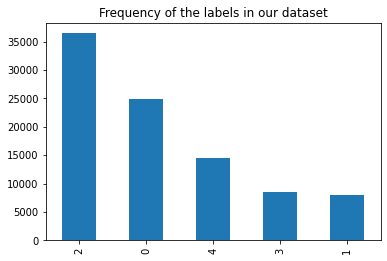

In [12]:
pd.Series(y).value_counts().plot.bar()
plt.title("Frequency of the labels in our dataset")

# Split the data into traing & test set (80:20)

In [13]:
from sklearn.model_selection import train_test_split
if VBS:
    print("Shape of the input data: {}".format(X.shape))
    print("Shape of the sleep stages: {}".format(y.shape))
# splitting subjects
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train_fpz_cz, X_test_fpz_cz, Y_train_fpz_cz, Y_test_fpz_cz = train_test_split(X[:,:,0:1], y, test_size=0.2, random_state=seed)
X_train_pz_oz, X_test_pz_oz, Y_train_pz_oz, Y_test_pz_oz = train_test_split(X[:,:,1:2], y, test_size=0.2, random_state=seed)

if VBS:
    print("Shape of the training dataset:\ntraining dataset: {}\ntest dataset: {}\n"
          .format(X_train.shape, X_test.shape))
    print("Shape of the training dataset:\ntraining fpz_cz dataset: {}\ntest fpz_cz dataset: {}\n"
          .format(X_train_fpz_cz.shape, X_test_fpz_cz.shape))
    print("Shape of the training dataset:\ntraining pz_oz dataset: {}\ntest pz_oz dataset: {}\n"
          .format(X_train_pz_oz.shape, X_test_pz_oz.shape))
    
#print(y_train)


Shape of the input data: (92343, 3000, 2)
Shape of the sleep stages: (92343,)
Shape of the training dataset:
training dataset: (73874, 3000, 2)
test dataset: (18469, 3000, 2)

Shape of the training dataset:
training fpz_cz dataset: (73874, 3000, 1)
test fpz_cz dataset: (18469, 3000, 1)

Shape of the training dataset:
training pz_oz dataset: (73874, 3000, 1)
test pz_oz dataset: (18469, 3000, 1)



In [14]:
from torch.utils.data import Dataset
class EEGDataset(Dataset):

    def __init__(self, a):
        """
        TODO: init the Dataset instance.
        """
        self.X = a[0]
        self.Y = a[1]

    def __len__(self):
        """
        TODO: Denotes the total number of samples
        """

        return len(self.Y)

    def __getitem__(self, i):
        return (self.X[i], self.Y[i])

# Create data loaders for all channel (fpz-cz & pz-oz), fpz-cz, and pz-oz

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

BATCH_SIZE = 50
# train & test data from fpz-cz and pz_oz
X_train = torch.tensor(X_train).float().detach().clone()
Y_train = torch.tensor(Y_train).long().detach().clone()
train_data_all = (X_train, Y_train)

X_test = torch.tensor(X_test).float().detach().clone()
Y_test = torch.tensor(Y_test).long().detach().clone()
test_data_all = (X_test, Y_test)

train_loader_all = torch.utils.data.DataLoader(EEGDataset(train_data_all), batch_size=BATCH_SIZE, shuffle=False)
test_loader_all =  torch.utils.data.DataLoader(EEGDataset(test_data_all), batch_size=BATCH_SIZE, shuffle=False)

# train & test data from fpz-cz
X_train_fpz_cz = torch.tensor(X_train_fpz_cz).float().detach().clone()
Y_train_fpz_cz = torch.tensor(Y_train_fpz_cz).long().detach().clone()
train_data_fpz_cz = (X_train_fpz_cz, Y_train_fpz_cz)

X_test_fpz_cz = torch.tensor(X_test_fpz_cz).float().detach().clone()
Y_test_fpz_cz = torch.tensor(Y_test_fpz_cz).long().detach().clone()
test_data_fpz_cz = (X_test_fpz_cz, Y_test_fpz_cz)

train_loader_fpz_cz = torch.utils.data.DataLoader(EEGDataset(train_data_fpz_cz), batch_size=BATCH_SIZE, shuffle=False)
test_loader_fpz_cz =  torch.utils.data.DataLoader(EEGDataset(test_data_fpz_cz), batch_size=BATCH_SIZE, shuffle=False)

# train & test data from pz-oz
X_train_pz_oz = torch.tensor(X_train_pz_oz).float().detach().clone()
Y_train_pz_oz = torch.tensor(Y_train_pz_oz).long().detach().clone()
train_data_pz_oz = (X_train_pz_oz, Y_train_pz_oz)

X_test_pz_oz= torch.tensor(X_test_pz_oz).float().detach().clone()
Y_test_pz_oz = torch.tensor(Y_test_pz_oz).long().detach().clone()
test_data_pz_oz = (X_test_pz_oz, Y_test_pz_oz)

train_loader_pz_oz = torch.utils.data.DataLoader(EEGDataset(train_data_pz_oz), batch_size=BATCH_SIZE, shuffle=False)
test_loader_pz_oz =  torch.utils.data.DataLoader(EEGDataset(test_data_pz_oz), batch_size=BATCH_SIZE, shuffle=False)

## Compute training metrics

In [16]:

def calculate_batch_accuracy_precision_recall_fscore(y_pred, y_true):
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support

    y_pred = torch.argmax(y_pred, dim=-1)
    y_pred = y_pred.cpu().data.numpy()
    y_true = y_true.cpu().data.numpy()
    (precision, recall, fscore, _) = precision_recall_fscore_support(y_true, y_pred, average='macro',warn_for=tuple())
    accuracy = accuracy_score(y_pred, y_true)
    #print(precision, recall, fscore)
    return precision, recall, fscore, accuracy

# Model training...

In [17]:
def train_model(model, train_loader, n_epoch=5, lr=0.003, device=None):
    import torch.optim as optim
    """
    Comments goes here
    """
    device = device or torch.device('cpu') #use GPU if available
   
    loss_history = []

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    model.train()
    epoch_precision_hist, epoch_recall_hist, epoch_fscore_hist, epoch_accuracy_hist = ([] for i in range(4))

    for epoch in range(n_epoch):
        curr_epoch_loss = []
        precision, recall, fscore, accuracy = ([] for i in range(4))
        count = 0
        for X, Y in train_loader:
            optimizer.zero_grad()
            
            X = X.detach().clone().to(device)
            Y = Y.detach().clone().to(device)
            Y_hat = model(X, device).float()
            Y = Y.long()

            loss = criterion(Y_hat, Y)
            loss.backward()
            optimizer.step()

            # Appending loss     
            curr_epoch_loss.append(loss.cpu().data.numpy())

            # measure all metrics for the training batch
            batch_precision, batch_recall, batch_fscore, batch_acc = calculate_batch_accuracy_precision_recall_fscore(Y_hat, Y)
            accuracy.append(batch_acc)
            fscore.append(batch_fscore)
            recall.append(batch_recall)
            precision.append(batch_precision)
            count+=1
            #print(count,"/",len(train_loader),"---lr->",lr,"---------acc->", batch_acc, "  --- loss ->", loss)
            print(f"\repoch{epoch} | progress->{count}/{len(train_loader)} ", end="")

        # compute epoch loss i.e. mean of all batch losses and other training metrics
        epoch_accuracy = np.mean(accuracy)
        epoch_accuracy_hist.append(epoch_accuracy)
        epoch_precision_hist.append(np.mean(precision))
        epoch_recall_hist.append(np.mean(recall))
        epoch_fscore_hist.append(np.mean(fscore))

        loss_history.append(round(np.mean(curr_epoch_loss),5))

        print(f"current epoch loss={round(np.mean(curr_epoch_loss),5)},current epoch accuracy={round(epoch_accuracy,5)}")


        #print(f"current epoch loss={round(np.mean(curr_epoch_loss),5)},current epoch accuracy={round(epoch_accuracy,5)},time={datetime.now().strftime("%Y-%m-%d %H:%M")}" )
        #print(datetime.now().strftime("%Y-%m-%d %H:%M"), "epoch_accuracy->", round(epoch_accuracy,5))
        
        exp_lr_scheduler.step() # change learning rate

    return model, loss_history, epoch_accuracy_hist, epoch_precision_hist, epoch_recall_hist, epoch_fscore_hist

# Base model from the paper by Tsinalis,et al. (2016)
https://arxiv.org/pdf/1610.01683.pdf

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SleepCNN_1D_Tsinalis(nn.Module):
    """Replication of the CNN architecture used by Tsinalis,et al. (2016)
    https://arxiv.org/pdf/1610.01683.pdf
    """

    def __init__(self, n = 1):
        super(SleepCNN_1D_Tsinalis, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=n, out_channels=20, kernel_size=200, stride=1)
        self.pool1 = nn.MaxPool1d(kernel_size=20, stride=10)
        self.conv2 = nn.Conv2d(
            in_channels=1, out_channels=400, kernel_size=(20, 30), stride=(1, 1))
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 10), stride=(1, 2))
        #self.fc1 = nn.Linear(in_features=400 * 721, out_features=500)
        self.fc1 = nn.Linear(in_features=400 * 121, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=5)

    def forward(self, x, dev):
        x = x.permute(0,2,1).to(dev)
        # One dimensional convolution/pooling
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        # Stack, two-dimensional convolution/pooling
        x = x.unsqueeze(1)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        #print(x.shape)
        # Reshape, fully connected layers
        x = x.view(-1, 400 * 121)#400 * 721)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

# Check if GPU available, use if available

In [19]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
  dev = "cuda:0"
  torch.cuda.empty_cache()
else:
  dev = "cpu"
device = torch.device(dev)
print(datetime.now().strftime("%Y-%m-%d %H:%M"))



True
2021-05-04 14:06


# Hyperparameters for training

In [20]:
n_epoch = 15
lr = .0001 #0.003

In [21]:
# All the channel
# fpz-cz and pz-oz training 
print('Training with fpz-cz and pz-oz data...')
print('Start time: ', datetime.now().strftime("%Y-%m-%d %H:%M"))

n_dim=2#number of channels which includes fpz-cz and pz-oz

model = SleepCNN_1D_Tsinalis(n_dim)
model = model.to(device)

model, loss_history, epoch_accuracy_hist, epoch_precision_hist, epoch_recall_hist, epoch_fscore_hist = train_model(model, train_loader_all, n_epoch=n_epoch, lr=lr, device=device)
torch.save(model, os.path.join(project_path, "SleepCNN_multichannel.pth"))
print('End time: ', datetime.now().strftime("%Y-%m-%d %H:%M"))


Training with fpz-cz and pz-oz data...
Start time:  2021-05-04 14:06
epoch0 | progress->1478/1478 current epoch loss=1.1326500177383423,current epoch accuracy=0.54222
epoch1 | progress->1478/1478 current epoch loss=0.7798100113868713,current epoch accuracy=0.69984
epoch2 | progress->1478/1478 current epoch loss=0.7044699788093567,current epoch accuracy=0.72883
epoch3 | progress->1478/1478 current epoch loss=0.6500800251960754,current epoch accuracy=0.75094
epoch4 | progress->1478/1478 current epoch loss=0.6436600089073181,current epoch accuracy=0.75413
epoch5 | progress->1478/1478 current epoch loss=0.63823002576828,current epoch accuracy=0.75654
epoch6 | progress->1478/1478 current epoch loss=0.6311299800872803,current epoch accuracy=0.75979
epoch7 | progress->1478/1478 current epoch loss=0.6302599906921387,current epoch accuracy=0.75967
epoch8 | progress->1478/1478 current epoch loss=0.6296799778938293,current epoch accuracy=0.75984
epoch9 | progress->1478/1478 current epoch loss=0.6

In [22]:
#fpz-cz training
print('fpz-cz training', datetime.now().strftime("%Y-%m-%d %H:%M"))

n_dim=1#number of channels as its fpz-cz

model_fpz_cz = SleepCNN_1D_Tsinalis(n_dim)
model_fpz_cz = model_fpz_cz.to(device)

model_fpz_cz, loss_history_fpz_cz, epoch_accuracy_hist_fpz_cz, epoch_precision_hist_fpz_cz, epoch_recall_hist_fpz_cz, epoch_fscore_hist_fpz_cz = train_model(model_fpz_cz, train_loader_fpz_cz, n_epoch=n_epoch, lr=lr, device=device)
torch.save(model_fpz_cz, os.path.join(project_path, "SleepCNN_fpz_cz_channel.pth"))

fpz-cz training 2021-05-04 14:16
epoch0 | progress->1478/1478 current epoch loss=1.146939992904663,current epoch accuracy=0.52145
epoch1 | progress->1478/1478 current epoch loss=0.8351100087165833,current epoch accuracy=0.67078
epoch2 | progress->1478/1478 current epoch loss=0.7235100269317627,current epoch accuracy=0.71779
epoch3 | progress->1478/1478 current epoch loss=0.6626899838447571,current epoch accuracy=0.74473
epoch4 | progress->1478/1478 current epoch loss=0.6552900075912476,current epoch accuracy=0.74742
epoch5 | progress->1478/1478 current epoch loss=0.6494699716567993,current epoch accuracy=0.74955
epoch6 | progress->1478/1478 current epoch loss=0.6416199803352356,current epoch accuracy=0.75329
epoch7 | progress->1478/1478 current epoch loss=0.6409100294113159,current epoch accuracy=0.75305
epoch8 | progress->1478/1478 current epoch loss=0.6402999758720398,current epoch accuracy=0.75324
epoch9 | progress->1478/1478 current epoch loss=0.6394100189208984,current epoch accur

In [23]:
#pz-oz training
print('pz-oz training', datetime.now().strftime("%Y-%m-%d %H:%M"))
n_dim=1#number of channels as its pz-oz

model_pz_oz = SleepCNN_1D_Tsinalis(n_dim)
model_pz_oz = model_pz_oz.to(device)

model_pz_oz, loss_history_pz_oz, epoch_accuracy_hist_pz_oz, epoch_precision_hist_pz_oz, epoch_recall_hist_pz_oz, epoch_fscore_hist_pz_oz = train_model(model_pz_oz, train_loader_pz_oz, n_epoch=n_epoch, lr=lr, device=device)
torch.save(model_pz_oz, os.path.join(project_path, "SleepCNN_pz_oz_channel.pth"))

pz-oz training 2021-05-04 14:25
epoch0 | progress->1478/1478 current epoch loss=1.3295199871063232,current epoch accuracy=0.44466
epoch1 | progress->1478/1478 current epoch loss=0.856719970703125,current epoch accuracy=0.66493
epoch2 | progress->1478/1478 current epoch loss=0.7857400178909302,current epoch accuracy=0.68949
epoch3 | progress->1478/1478 current epoch loss=0.743179976940155,current epoch accuracy=0.70862
epoch4 | progress->1478/1478 current epoch loss=0.7392799854278564,current epoch accuracy=0.70998
epoch5 | progress->1478/1478 current epoch loss=0.7358599901199341,current epoch accuracy=0.71139
epoch6 | progress->1478/1478 current epoch loss=0.729960024356842,current epoch accuracy=0.71456
epoch7 | progress->1478/1478 current epoch loss=0.7294399738311768,current epoch accuracy=0.71458
epoch8 | progress->1478/1478 current epoch loss=0.7290599942207336,current epoch accuracy=0.7146
epoch9 | progress->1478/1478 current epoch loss=0.7282599806785583,current epoch accuracy=

Text(0, 0.5, 'Cross entropy loss')

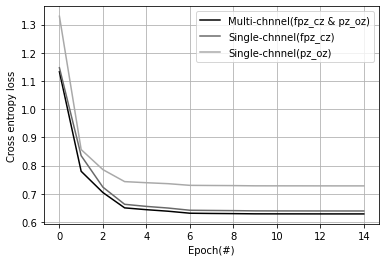

In [34]:
#plt.title("Training loss by epochs")
plt.plot(loss_history, label = "Multi-chnnel(fpz_cz & pz_oz)", color ="black")
plt.plot(loss_history_fpz_cz, label = "Single-chnnel(fpz_cz)", color ="dimgrey")
plt.plot(loss_history_pz_oz, label = "Single-chnnel(pz_oz)", color ="darkgrey")
plt.legend()
plt.grid()
plt.xlabel("Epoch(#)")
plt.ylabel("Cross entropy loss")

Text(0, 0.5, 'Training accuracy')

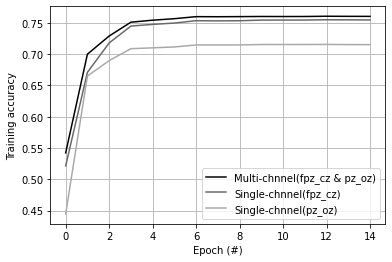

In [35]:
#plt.title("Training accuracy by epochs")
plt.plot(epoch_accuracy_hist,label = "Multi-chnnel(fpz_cz & pz_oz)", color ="black")
plt.plot(epoch_accuracy_hist_fpz_cz, label = "Single-chnnel(fpz_cz)", color ="dimgrey")
plt.plot(epoch_accuracy_hist_pz_oz, label = "Single-chnnel(pz_oz)", color ="darkgrey")
plt.legend()
plt.grid()
plt.xlabel("Epoch (#)")
plt.ylabel("Training accuracy")

Text(0, 0.5, 'Precision')

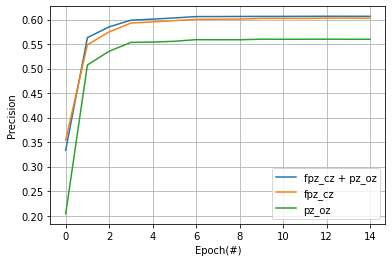

In [27]:
#plt.title("Training precision by epochs")
plt.plot(epoch_precision_hist,label = "fpz_cz + pz_oz")
plt.plot(epoch_precision_hist_fpz_cz,label = "fpz_cz")
plt.plot(epoch_precision_hist_pz_oz,label = "pz_oz")
plt.legend()
plt.grid()
plt.xlabel("Epoch(#)")
plt.ylabel("Precision")

Text(0, 0.5, 'recall')

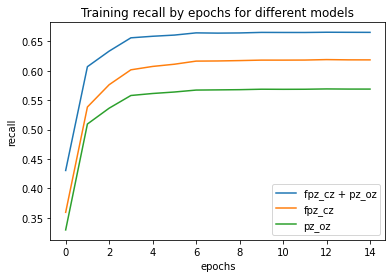

In [28]:
plt.title("Training recall by epochs for different models")
plt.plot(epoch_recall_hist,label = "fpz_cz + pz_oz")
plt.plot(epoch_recall_hist_fpz_cz,label = "fpz_cz")
plt.plot(epoch_recall_hist_pz_oz,label = "pz_oz")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("recall")

Text(0, 0.5, 'Training F1-score')

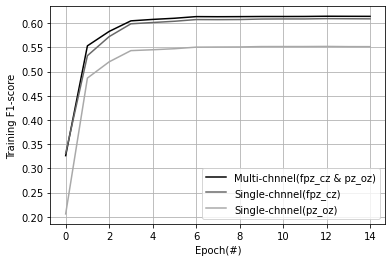

In [37]:
#plt.title("Training f1-score by epochs")
plt.plot(epoch_fscore_hist, label = "Multi-chnnel(fpz_cz & pz_oz)", color ="black")
plt.plot(epoch_fscore_hist_fpz_cz, label = "Single-chnnel(fpz_cz)", color ="dimgrey")
plt.plot(epoch_fscore_hist_pz_oz, label = "Single-chnnel(pz_oz)", color ="darkgrey")
plt.legend()
plt.grid()
plt.xlabel("Epoch(#)")
plt.ylabel("Training F1-score")

In [38]:
def eval_model(model, dataloader, device=None):
    """
    Comments goes here
    """
    device = device or torch.device('cpu')
    model.eval()
    pred_all = []
    Y_test = []
    for X, Y in dataloader:
        X = X.detach().clone().to(device)
        Y = Y.detach().clone().to(device)
        Y_hat = model(X, device).float()
        Y_hat = torch.softmax(Y_hat, dim=1)
        pred_all.append(Y_hat.cpu().detach().numpy())
        Y_test.append(Y.cpu().detach().numpy())
    pred_all = np.concatenate(pred_all, axis=0)
    Y_test = np.concatenate(Y_test, axis=0)

    return pred_all, Y_test     

def evaluate_predictions(truth, pred):

    from sklearn.metrics import roc_auc_score, f1_score, cohen_kappa_score
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    from sklearn.metrics import confusion_matrix
  
    pred_hat = np.argmax(pred, axis=1)

    auroc = roc_auc_score(truth, pred, multi_class='ovr')
    f1 = f1_score(truth, pred_hat, average='micro')
    kappa = cohen_kappa_score(truth, pred_hat)


    #(precision, recall, fscore, _) = precision_recall_fscore_support(truth, pred_hat, average='macro',warn_for=tuple())
    accuracy = accuracy_score(pred_hat, truth)
    cm = confusion_matrix(truth, pred_hat)

    return round(auroc,5), round(f1,5), round(kappa,5), round(accuracy,5),cm


In [39]:
print("--------final Eval---of all Channels-----")
pred, truth = eval_model(model, test_loader_all, device=device)
auroc, f1, kappa, accuracy,cm = evaluate_predictions(truth, pred)
print(f"All Channels AUROC={auroc} , F1={f1}, accuracy ={accuracy}, and Cohen's Kappa ={kappa}")
print(cm)


--------final Eval---of all Channels-----
All Channels AUROC=0.91627 , F1=0.76241, accuracy =0.76241, and Cohen's Kappa =0.66506
[[4558    2   86   14  305]
 [ 301    2  637    7  674]
 [ 135    4 6388  241  604]
 [  17    0  264 1360    1]
 [ 194    3  898    1 1773]]


In [54]:
print("--------final Eval---of fpz-cz-----")
pred, truth = eval_model(model_fpz_cz, test_loader_fpz_cz, device=device)
auroc, f1, kappa,accuracy,cm = evaluate_predictions(truth, pred)
print(f"fpz-cz channel AUROC={auroc}, F1={f1}, accuracy ={accuracy}, and Cohen's Kappa ={kappa}")
print(cm)


--------final Eval---of fpz-cz-----
fpz-cz channel AUROC=0.91668, F1=0.75884, accuracy =0.75884, and Cohen's Kappa =0.65977
[[4466    1   99   14  385]
 [ 310    4  602    3  702]
 [ 122    0 6459  215  576]
 [  21    0  240 1378    3]
 [ 224    0  936    1 1708]]


In [41]:
print("--------final Eval---of pz-oz-----")
pred, truth = eval_model(model_pz_oz, test_loader_pz_oz, device=device)
auroc, f1, kappa,accuracy,cm = evaluate_predictions(truth, pred)
print(f"pz-oz channel AUROC={auroc} , F1={f1}, accuracy ={accuracy}, and Cohen's Kappa ={kappa}")
print(cm)

--------final Eval---of pz-oz-----
pz-oz channel AUROC=0.89536 , F1=0.71731, accuracy =0.71731, and Cohen's Kappa =0.59523
[[4534    2   92    5  332]
 [ 427    1  636    3  554]
 [ 115    3 6366  325  563]
 [  14    0  533 1088    7]
 [ 252    1 1355    2 1259]]


In [ ]:
print("End of run-->",datetime.now().strftime("%Y-%m-%d %H:%M"))

End of run--> 2021-04-25 04:01


# Enhanced MintNet model 

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SleepCNN_1D_MintNet(nn.Module):
    """MintNet CNN architecture inspired by CNN architecture of Tsinalis,et al. (2016)
    https://arxiv.org/pdf/1610.01683.pdf
    """

    def __init__(self, n = 1):
        super(SleepCNN_1D_MintNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=n, out_channels=20, kernel_size=200, stride=1)
        self.bn1 = nn.BatchNorm1d(num_features=20)
        self.pool1 = nn.MaxPool1d(kernel_size=20, stride=10)
        self.conv2 = nn.Conv2d(
            in_channels=1, out_channels=400, kernel_size=(20, 30), stride=(1, 1))
        self.bn2 = nn.BatchNorm2d(num_features=400)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 10), stride=(1, 2))

        self.conv3 = nn.Conv2d(in_channels=400, out_channels=100, kernel_size=(1,10),stride=(1,1))
        self.bn3 = nn.BatchNorm2d(num_features=100)
        self.pool3 = nn.MaxPool2d(kernel_size=(1, 10), stride=(5, 7))

        #self.fc1 = nn.Linear(in_features=400 * 121, out_features=500)
        self.fc1 = nn.Linear(in_features=100*15, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=5)

    def forward(self, x, dev):
        x = x.permute(0,2,1).to(dev)

        # One dimensional convolution/pooling
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        # Stack, two-dimensional convolution/pooling
        x = x.unsqueeze(1)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)

        # Reshape, fully connected layers
        x = x.view(-1,100*15)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [44]:
#fpz-cz and pz-oz training
print('fpz-cz and pz-oz training', datetime.now().strftime("%Y-%m-%d %H:%M"))
n_dim=2#number of channels which includes fpz-cz and pz-oz

model_mintNet = SleepCNN_1D_MintNet(n_dim)
model_mintNet = model_mintNet.to(device)

model_mintNet, loss_history_mintNet, epoch_accuracy_hist_mintNet, epoch_precision_hist_mintNet, epoch_recall_hist_mintNet, epoch_fscore_hist_mintNet = train_model(model_mintNet, train_loader_all, n_epoch=n_epoch, lr=lr, device=device)
torch.save(model_mintNet, os.path.join(project_path, "SleepCNN_multichannel_model_mintNet.pth"))

fpz-cz and pz-oz training 2021-05-04 14:58
epoch0 | progress->1478/1478 current epoch loss=0.5942299962043762,current epoch accuracy=0.77323
epoch1 | progress->1478/1478 current epoch loss=0.4998700022697449,current epoch accuracy=0.80825
epoch2 | progress->1478/1478 current epoch loss=0.47099000215530396,current epoch accuracy=0.81945
epoch3 | progress->1478/1478 current epoch loss=0.41721999645233154,current epoch accuracy=0.84241
epoch4 | progress->1478/1478 current epoch loss=0.4053800106048584,current epoch accuracy=0.84641
epoch5 | progress->1478/1478 current epoch loss=0.3970800042152405,current epoch accuracy=0.84971
epoch6 | progress->1478/1478 current epoch loss=0.38611000776290894,current epoch accuracy=0.85374
epoch7 | progress->1478/1478 current epoch loss=0.38453999161720276,current epoch accuracy=0.85458
epoch8 | progress->1478/1478 current epoch loss=0.38350000977516174,current epoch accuracy=0.855
epoch9 | progress->1478/1478 current epoch loss=0.3821299970149994,curre

In [39]:
#fpz-cz training
print('fpz-cz training', datetime.now().strftime("%Y-%m-%d %H:%M"))

n_dim=1#number of channels as its fpz-cz

model_fpz_cz_mintNet = SleepCNN_1D_MintNet(n_dim)
model_fpz_cz_mintNet = model_fpz_cz_mintNet.to(device)

model_fpz_cz_mintNet, loss_history_fpz_cz_mintNet, epoch_accuracy_hist_fpz_cz_mintNet, epoch_precision_hist_fpz_cz_mintNet, epoch_recall_hist_fpz_cz_mintNet, epoch_fscore_hist_fpz_cz_mintNet = train_model(model_fpz_cz_mintNet, train_loader_fpz_cz, n_epoch=n_epoch, lr=lr, device=device)
torch.save(model_fpz_cz_mintNet, os.path.join(project_path, "SleepCNN_fpz_cz_channel_mintNet.pth"))

fpz-cz training 2021-05-04 02:04
epoch0 | progress->1663/1663 current epoch loss=0.6278499960899353,current epoch accuracy=0.75512
epoch1 | progress->1663/1663 current epoch loss=0.5347999930381775,current epoch accuracy=0.79431
epoch2 | progress->1663/1663 current epoch loss=0.5064600110054016,current epoch accuracy=0.80532
epoch3 | progress->1663/1663 current epoch loss=0.455130010843277,current epoch accuracy=0.82721
epoch4 | progress->1663/1663 current epoch loss=0.4450399875640869,current epoch accuracy=0.83105
epoch5 | progress->1663/1663 current epoch loss=0.43792998790740967,current epoch accuracy=0.8337
epoch6 | progress->1663/1663 current epoch loss=0.4278300106525421,current epoch accuracy=0.83816
epoch7 | progress->1663/1663 current epoch loss=0.42649999260902405,current epoch accuracy=0.83883
epoch8 | progress->1663/1663 current epoch loss=0.4256100058555603,current epoch accuracy=0.83919
epoch9 | progress->1663/1663 current epoch loss=0.42430999875068665,current epoch acc

In [49]:
#pz-oz training
print('pz-oz training', datetime.now().strftime("%Y-%m-%d %H:%M"))
n_dim=1#number of channels as its pz-oz

model_pz_oz_mintNet = SleepCNN_1D_MintNet(n_dim)
model_pz_oz_mintNet = model_pz_oz_mintNet.to(device)

model_pz_oz_mintNet, loss_history_pz_oz_mintNet, epoch_accuracy_hist_pz_oz_mintNet, epoch_precision_hist_pz_oz_mintNet, epoch_recall_hist_pz_oz_mintNet, epoch_fscore_hist_pz_oz_mintNet = train_model(model_pz_oz_mintNet, train_loader_pz_oz, n_epoch=n_epoch, lr=lr, device=device)
torch.save(model_pz_oz_mintNet, os.path.join(project_path, "SleepCNN_pz_oz_channel_mintNet.pth"))

pz-oz training 2021-05-04 02:44
epoch0 | progress->1478/1478 current epoch loss=0.7413600087165833,current epoch accuracy=0.70816
epoch1 | progress->1478/1478 current epoch loss=0.6525400280952454,current epoch accuracy=0.74654
epoch2 | progress->1478/1478 current epoch loss=0.6172299981117249,current epoch accuracy=0.76178
epoch3 | progress->1478/1478 current epoch loss=0.5627899765968323,current epoch accuracy=0.78595
epoch4 | progress->1478/1478 current epoch loss=0.5512999892234802,current epoch accuracy=0.79025
epoch5 | progress->1478/1478 current epoch loss=0.5435500144958496,current epoch accuracy=0.793
epoch6 | progress->1478/1478 current epoch loss=0.5329700112342834,current epoch accuracy=0.79768
epoch7 | progress->1478/1478 current epoch loss=0.5315899848937988,current epoch accuracy=0.79828
epoch8 | progress->1478/1478 current epoch loss=0.5306599736213684,current epoch accuracy=0.79855
epoch9 | progress->1478/1478 current epoch loss=0.5294899940490723,current epoch accurac

Text(0, 0.5, 'Cross entropy loss')

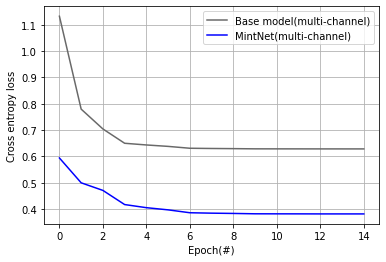

In [48]:
#plt.title("Training loss by epochs")
plt.plot(loss_history, label = "Base model(multi-channel)", color="dimgrey")
#plt.plot(loss_history_fpz_cz, label = "fpz_cz")
#plt.plot(loss_history_pz_oz, label = "pz_oz")
plt.plot(loss_history_mintNet, label = "MintNet(multi-channel)", color="blue")
#plt.plot(loss_history_fpz_cz_mintNet, label = "fpz_cz with MintNet")
#plt.plot(loss_history_pz_oz_mintNet, label = "pz_oz with MintNet")
plt.legend()
plt.grid()
plt.xlabel("Epoch(#)")
plt.ylabel("Cross entropy loss")

Text(0, 0.5, 'Training accuracy')

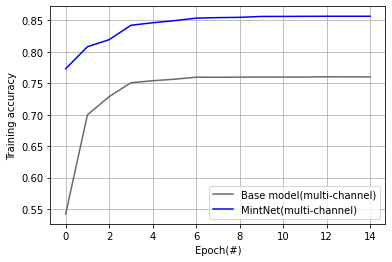

In [49]:
#plt.title("Training accuracy by epochs")
plt.plot(epoch_accuracy_hist,label = "Base model(multi-channel)", color="dimgrey")
#plt.plot(epoch_accuracy_hist_fpz_cz, label = "fpz_cz")
#plt.plot(epoch_accuracy_hist_pz_oz, label = "pz_oz")
plt.plot(epoch_accuracy_hist_mintNet,label = "MintNet(multi-channel)", color="blue")
#plt.plot(epoch_accuracy_hist_fpz_cz_mintNet, label = "fpz_cz with MintNet")
#plt.plot(epoch_accuracy_hist_pz_oz_mintNet, label = "pz_oz with MintNet")
plt.legend()
plt.grid()
plt.xlabel("Epoch(#)")
plt.ylabel("Training accuracy")

Text(0, 0.5, 'precision')

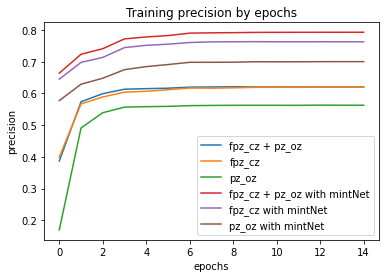

In [ ]:
plt.title("Training precision by epochs")
plt.plot(epoch_precision_hist,label = "fpz_cz + pz_oz")
plt.plot(epoch_precision_hist_fpz_cz,label = "fpz_cz")
plt.plot(epoch_precision_hist_pz_oz,label = "pz_oz")
plt.plot(epoch_precision_hist_mintNet,label = "fpz_cz + pz_oz with mintNet")
plt.plot(epoch_precision_hist_fpz_cz_mintNet,label = "fpz_cz with mintNet")
plt.plot(epoch_precision_hist_pz_oz_mintNet,label = "pz_oz with mintNet")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("precision")

Text(0, 0.5, 'recall')

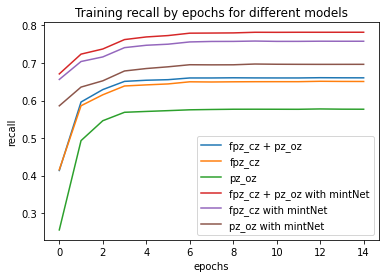

In [ ]:
plt.title("Training recall by epochs for different models")
plt.plot(epoch_recall_hist,label = "fpz_cz + pz_oz")
plt.plot(epoch_recall_hist_fpz_cz,label = "fpz_cz")
plt.plot(epoch_recall_hist_pz_oz,label = "pz_oz")
plt.plot(epoch_recall_hist_mintNet,label = "fpz_cz + pz_oz with mintNet")
plt.plot(epoch_recall_hist_fpz_cz_mintNet,label = "fpz_cz with mintNet")
plt.plot(epoch_recall_hist_pz_oz_mintNet,label = "pz_oz with mintNet")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("recall")

Text(0, 0.5, 'Training F1-score')

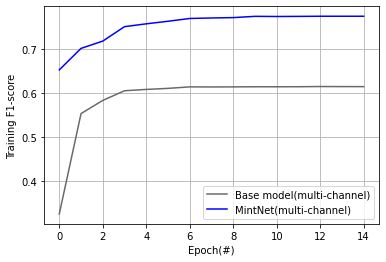

In [51]:
#plt.title("Training f1-score by epochs")
plt.plot(epoch_fscore_hist, label = "Base model(multi-channel)", color="dimgrey")
#plt.plot(epoch_fscore_hist_fpz_cz, label = "fpz_cz")
#plt.plot(epoch_fscore_hist_pz_oz, label = "pz_oz")
plt.plot(epoch_fscore_hist_mintNet, label = "MintNet(multi-channel)", color="blue")
#plt.plot(epoch_fscore_hist_fpz_cz_mintNet, label = "fpz_cz with mintNet")
#plt.plot(epoch_fscore_hist_pz_oz_mintNet, label = "pz_oz with mintNet")
plt.legend()
plt.grid()
plt.xlabel("Epoch(#)")
plt.ylabel("Training F1-score")

In [52]:
print("--------final Eval---of all Channels---MintNet--")
pred, truth = eval_model(model_mintNet, test_loader_all, device=device)
auroc, f1, kappa, accuracy,cm = evaluate_predictions(truth, pred)
print(f"All Channels AUROC={auroc} , F1={f1}, accuracy ={accuracy}, and Cohen's Kappa ={kappa}")
print(cm)

--------final Eval---of all Channels---MintNet--
All Channels AUROC=0.96196 , F1=0.8465, accuracy =0.8465, and Cohen's Kappa =0.7866
[[4720  120   45    4   76]
 [ 222  471  574    3  351]
 [  49  171 6648  169  335]
 [  10    0  258 1373    1]
 [  69  106  272    0 2422]]


In [51]:
print("--------final Eval---of fpz-cz--MintNet---")
pred, truth = eval_model(model_fpz_cz_mintNet, test_loader_fpz_cz, device=device)
auroc, f1, kappa,accuracy,cm = evaluate_predictions(truth, pred)
print(f"fpz-cz channel AUROC={auroc}, F1={f1}, accuracy ={accuracy}, and Cohen's Kappa ={kappa}")
print(cm)

--------final Eval---of fpz-cz--MintNet---
fpz-cz channel AUROC=0.95942, F1=0.83843, accuracy =0.83843, and Cohen's Kappa =0.7763
[[4716  110   39    3   97]
 [ 259  403  520    4  435]
 [  56  165 6543  203  405]
 [   9    0  216 1417    0]
 [ 129  121  213    0 2406]]


In [52]:
print("--------final Eval---of pz-oz--MintNet---")
pred, truth = eval_model(model_pz_oz_mintNet, test_loader_pz_oz, device=device)
auroc, f1, kappa,accuracy,cm = evaluate_predictions(truth, pred)
print(f"pz-oz channel AUROC={auroc} , F1={f1}, accuracy ={accuracy}, and Cohen's Kappa ={kappa}")
print(cm)

--------final Eval---of pz-oz--MintNet---
pz-oz channel AUROC=0.93564 , F1=0.78856, accuracy =0.78856, and Cohen's Kappa =0.7041
[[4775   29   58    1  102]
 [ 467  124  481   12  537]
 [ 125   83 6316  262  586]
 [  15    0  455 1169    3]
 [ 227   54  408    0 2180]]


#K-fold cross validation...for all channels

In [53]:
'''
https://www.machinecurve.com/index.php/2021/02/03/how-to-use-k-fold-cross-validation-with-pytorch/

'''

def reset_weights(m):
  '''
  Try resetting model weights to avoid weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

from sklearn.model_selection import KFold


# convert X,y into torch tensor
X_train = torch.tensor(X).float().detach().clone()
Y_train = torch.tensor(y).long().detach().clone()
dataset = (X_train, Y_train)
#print(dataset.shape)

# Configuration options
k_folds = 10
BATCH_SIZE = 50

n_epoch = 15
lr = .0001 #learning rate
loss_function = nn.CrossEntropyLoss()
n_dim=2 #number of channels i.e. fpz_cz & pz-oz

#print(torch.cuda.is_available())
if torch.cuda.is_available():
  dev = "cuda:0"
  torch.cuda.empty_cache()
else:
  dev = "cpu"
device = torch.device(dev) #use GPU if available
  
# For fold results
# results = {}
auroc_all = [] 
f1_all = [] 
kappa_all = [] 
accuracy_all = []
  
# Set fixed random number seed
torch.manual_seed(42)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

print(f'Start time: {datetime.now().strftime("%Y-%m-%d %H:%M")}')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(EEGDataset(dataset))):
  
  # Start print
  print('--------------------------------')
  print(f'FOLD {fold}')
  print('--------------------------------')

  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
  # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(EEGDataset(dataset), 
                      batch_size=BATCH_SIZE, sampler=train_subsampler)
  testloader = torch.utils.data.DataLoader(EEGDataset(dataset),
                      batch_size=BATCH_SIZE, sampler=test_subsampler)
  

  # Init the neural network
  model_mintNet = SleepCNN_1D_MintNet(n_dim)
  model_mintNet = model_mintNet.to(device) #use GPU
  model_mintNet.apply(reset_weights)

   # Initialize optimizer
   # optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
  model_mintNet, epoch_loss, epoch_accuracy, epoch_precision, epoch_recall, epoch_fscore = train_model(model_mintNet, 
                                                                                                        trainloader, 
                                                                                                        n_epoch=n_epoch, 
                                                                                                        lr=lr, 
                                                                                                        device=device)
  # Process is complete.
  print('Training process has finished. Saving trained model.')

  # Saving the model
  # save_path = f'./model-fold-{fold}.pth'
  # torch.save(model_mintNet, os.path.join(project_path+str(fold), "model_mintNet.pth"))

  # Print about testing
  print('----------------------------------')
  print('Starting testing...')
  print('----------------------------------')

  pred, truth = eval_model(model_mintNet, testloader, device=device)
  auroc, f1, kappa, accuracy,cm = evaluate_predictions(truth, pred)
  print(f"All Channels AUROC={auroc} , F1={f1}, accuracy ={accuracy}, and Cohen's Kappa ={kappa}")

  auroc_all.append(auroc)
  f1_all.append(f1)
  kappa_all.append(kappa) 
  accuracy_all.append(accuracy)

  #print(cm)

print(f"{fold} average AUROC={np.mean(auroc_all)} , F1={np.mean(f1_all)}, accuracy ={np.mean(accuracy_all)}, and Cohen's Kappa ={np.mean(kappa_all)}")
print(f'End time: {datetime.now().strftime("%Y-%m-%d %H:%M")}')

Start time: 2021-05-04 15:17
--------------------------------
FOLD 0
--------------------------------
Reset trainable parameters of layer = Conv1d(2, 20, kernel_size=(200,), stride=(1,))
Reset trainable parameters of layer = BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(1, 400, kernel_size=(20, 30), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(400, 100, kernel_size=(1, 10), stride=(1, 1))
Reset trainable parameters of layer = BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=1500, out_features=500, bias=True)
Reset trainable parameters of layer = Linear(in_features=500, out_features=5, bias=True)
epoch0 | progress->1663/1663 current epoch loss=0.5846199989318848,current epoch accuracy=0.775